### Stacked LSTM

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df=pd.read_csv('coin_Bitcoin_aug.csv',header=0, index_col=0, parse_dates=True, squeeze=True)

In [ ]:
df.head()

Date
2013-04-29 23:59:59    144.539993
2013-04-30 23:59:59    139.000000
2013-05-01 23:59:59    116.989998
2013-05-02 23:59:59    105.209999
2013-05-03 23:59:59     97.750000
Name: Close, dtype: float64

In [ ]:
df.tail()

Date
2021-06-26 23:59:59    32243.4
2021-06-27 23:59:59    34678.5
2021-06-28 23:59:59    34475.9
2021-06-29 23:59:59    35834.7
2021-06-30 23:59:59    35026.9
Name: Close, dtype: float64

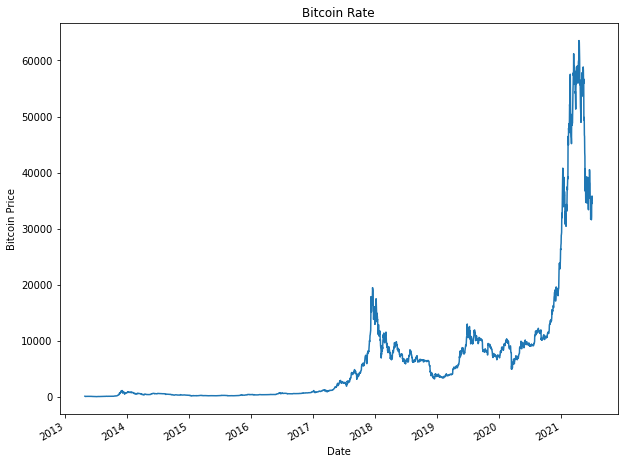

In [ ]:
plt.figure(figsize=(10,8))
plt.xlabel('Year')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Rate')
plt.grid(True)

df.plot()
plt.show()

In [ ]:
df1=df.reset_index()['Close']

In [ ]:
df1

0         144.539993
1         139.000000
2         116.989998
3         105.209999
4          97.750000
            ...     
2980    32243.400000
2981    34678.500000
2982    34475.900000
2983    35834.700000
2984    35026.900000
Name: Close, Length: 2985, dtype: float64

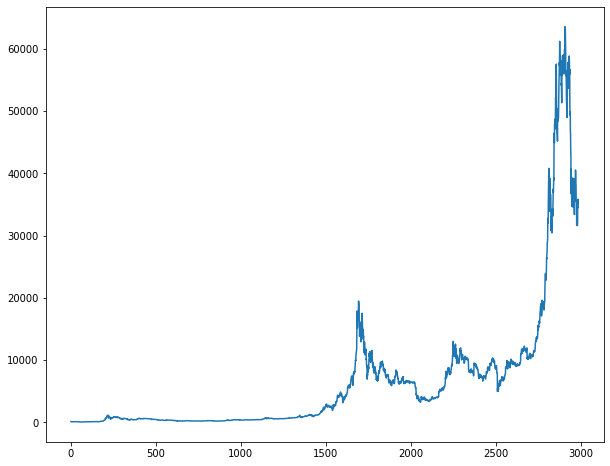

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

[[0.00119909]
 [0.0011118 ]
 [0.00076504]
 ...
 [0.54208493]
 [0.56349264]
 [0.55076586]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(1940, 1045)

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3.... and Y=t+101
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(1839, 100)
(1839,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(944, 100)
(944,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
29/29 [==============================] - 12s 238ms/step - loss: 6.4220e-04 - val_loss: 0.0026
Epoch 2/100
29/29 [==============================] - 6s 192ms/step - loss: 1.7367e-04 - val_loss: 0.0024
Epoch 3/100
29/29 [==============================] - 6s 193ms/step - loss: 1.2214e-04 - val_loss: 0.0032
Epoch 4/100
29/29 [==============================] - 6s 191ms/step - loss: 1.1265e-04 - val_loss: 0.0033
Epoch 5/100
29/29 [==============================] - 5s 190ms/step - loss: 1.0009e-04 - val_loss: 0.0053
Epoch 6/100
29/29 [==============================] - 6s 191ms/step - loss: 1.0293e-04 - val_loss: 0.0057
Epoch 7/100
29/29 [==============================] - 5s 189ms/step - loss: 9.0021e-05 - val_loss: 0.0067
Epoch 8/100
29/29 [==============================] - 6s 191ms/step - loss: 8.3204e-05 - val_loss: 0.0040
Epoch 9/100
29/29 [==============================] - 5s 190ms/step - loss: 8.4158e-05 - val_loss: 0.0058
Epoch 10/100
29/29 [==============================] - 

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
#math.sqrt(mean_squared_error(y_train,train_predict))
math.sqrt(mean_squared_error(ytest,test_predict))

0.034802520423086014

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

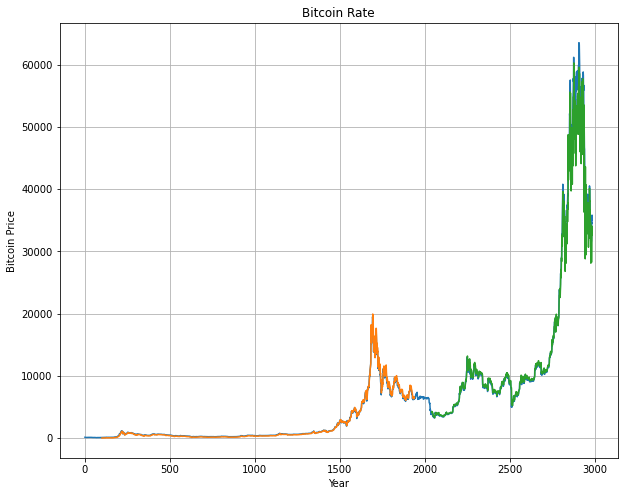

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions

plt.figure(figsize=(10,8))

plt.xlabel('Year')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Rate')
plt.grid(True)

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

1045

In [ ]:
# consider last 100 data points only to predict the future rate
x_input=test_data[945:].reshape(1,-1)
x_input.shape


(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 365 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<365):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

1 day output [[0.4799229]]
2 day output [[0.45216078]]
3 day output [[0.43000174]]
4 day output [[0.41194698]]
5 day output [[0.39638874]]
6 day output [[0.38225362]]
7 day output [[0.36907676]]
8 day output [[0.35680756]]
9 day output [[0.34557554]]
10 day output [[0.33552024]]
11 day output [[0.326706]]
12 day output [[0.3191057]]
13 day output [[0.31262153]]
14 day output [[0.30711702]]
15 day output [[0.302446]]
16 day output [[0.29847136]]
17 day output [[0.29507422]]
18 day output [[0.29215673]]
19 day output [[0.28963998]]
20 day output [[0.28746173]]
21 day output [[0.28557274]]
22 day output [[0.28393394]]
23 day output [[0.28251466]]
24 day output [[0.28129068]]
25 day output [[0.2802433]]
26 day output [[0.27935833]]
27 day output [[0.27862456]]
28 day output [[0.27803367]]
29 day output [[0.27757913]]
30 day output [[0.27725536]]
31 day output [[0.27705756]]
32 day output [[0.27698112]]
33 day output [[0.2770211]]
34 day output [[0.27717215]]
35 day output [[0.27742833]]
36

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,466)

In [ ]:
len(df1)

2985

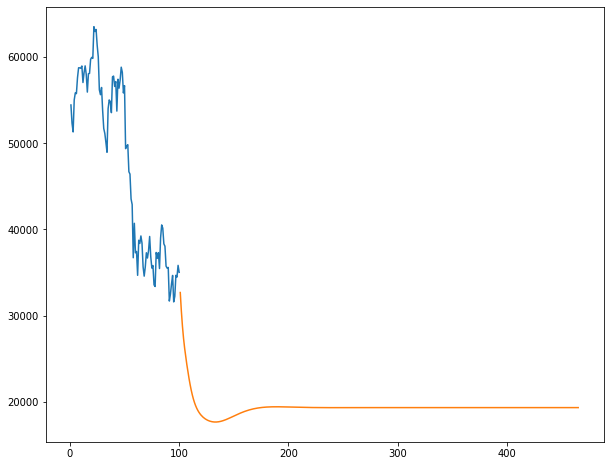

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(day_new,scaler.inverse_transform(df1[2885:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

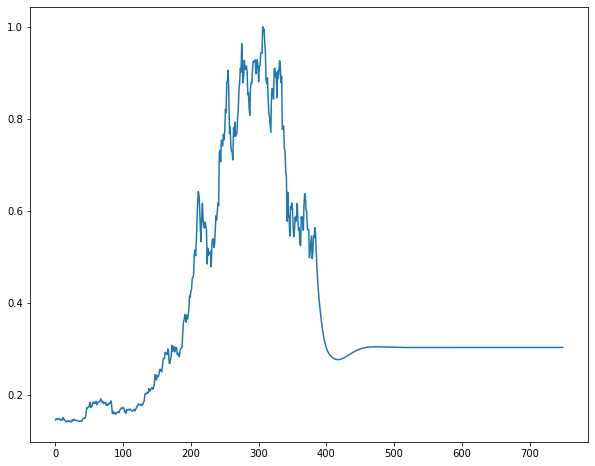

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.figure(figsize=(10,8))
plt.plot(df3[2600:])